# Load file names

In [1]:
import pandas as pd
import numpy as np

import os
import sys
from tqdm import tqdm
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
#import torchaudio
import pandas as pd
import numpy as np

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from Preprocessor import *
from Constants import *

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using TensorFlow backend.


In [2]:
Tess = "./TESS"

tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

preprocessor = DataPreprocessor()   
file_paths, labels = preprocessor.get_file_paths_and_labels(Tess)
labels = [label if label != "ps" else "surprise" for label in labels]
# dataframe for emotion of files
emotion_df = pd.DataFrame(labels, columns=['Emotions'])
print("ALL EMOTIONS:", set(labels))
# dataframe for path of files.
path_df = pd.DataFrame(file_paths, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

data = Tess_df

['./TESS/YAF_sad/YAF_wife_sad.wav', './TESS/YAF_sad/YAF_hate_sad.wav', './TESS/YAF_sad/YAF_phone_sad.wav', './TESS/YAF_sad/YAF_week_sad.wav', './TESS/YAF_sad/YAF_raid_sad.wav', './TESS/YAF_sad/YAF_base_sad.wav', './TESS/YAF_sad/YAF_book_sad.wav', './TESS/YAF_sad/YAF_lease_sad.wav', './TESS/YAF_sad/YAF_make_sad.wav', './TESS/YAF_sad/YAF_live_sad.wav', './TESS/YAF_sad/YAF_sub_sad.wav', './TESS/YAF_sad/YAF_goal_sad.wav', './TESS/YAF_sad/YAF_pool_sad.wav', './TESS/YAF_sad/YAF_tire_sad.wav', './TESS/YAF_sad/YAF_deep_sad.wav', './TESS/YAF_sad/YAF_knock_sad.wav', './TESS/YAF_sad/YAF_sell_sad.wav', './TESS/YAF_sad/YAF_note_sad.wav', './TESS/YAF_sad/YAF_back_sad.wav', './TESS/YAF_sad/YAF_dodge_sad.wav', './TESS/YAF_sad/YAF_met_sad.wav', './TESS/YAF_sad/YAF_choice_sad.wav', './TESS/YAF_sad/YAF_cab_sad.wav', './TESS/YAF_sad/YAF_gap_sad.wav', './TESS/YAF_sad/YAF_pass_sad.wav', './TESS/YAF_sad/YAF_half_sad.wav', './TESS/YAF_sad/YAF_thumb_sad.wav', './TESS/YAF_sad/YAF_calm_sad.wav', './TESS/YAF_sad/

# Load the signals

In [3]:
mel_spectrograms = []
signals = []
SAMPLE_RATE = 48000
for i, file_path in enumerate(data['Path']):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    
    signals.append(signal)
    print("\r Processed {}/{} files".format(i,len(data)),end='')
signals = np.stack(signals,axis=0)

 Processed 2799/2800 files

# Split the data

In [4]:
X = signals
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]

EMOTIONS = {0:'neutral', 1:'happy', 2:'sad', 3:'angry', 4:'fear', 5:'disgust', 6:'surprise'}

for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotions==EMOTIONS[emotion],'Emotions'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(2240, 144000), Y_train:(2240,)
X_val:(280, 144000), Y_val:(280,)
X_test:(280, 144000), Y_test:(280,)
Number of unique indexes is 2800, out of 2800


In [5]:
signals = None

In [6]:
X = None

# Augment signals by adding AWGN

In [ ]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [ ]:
aug_signals = []
aug_labels = []
for i in range(X_train.shape[0]):
    signal = X_train[i,:]
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        aug_labels.append(data.loc[i,"Emotions"])
        aug_signals.append(augmented_signals[j,:])
        data = data.append(data.iloc[i], ignore_index=True)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
aug_signals = np.stack(aug_signals,axis=0)
X_train = np.concatenate([X_train,aug_signals],axis=0)
aug_labels = np.stack(aug_labels,axis=0)
Y_train = np.concatenate([Y_train,aug_labels])
print('')
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')

# Calculate mel spectrograms

MEL spectrogram shape:  (128, 563)


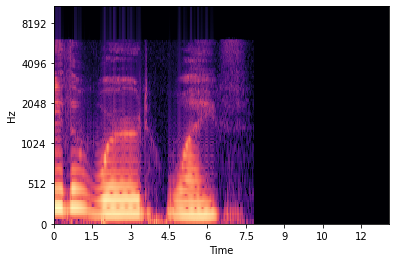

In [7]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

In [8]:
mel_train = []
print("Calculatin mel spectrograms for train set")
for i in range(X_train.shape[0]):
    mel_spectrogram = getMELspectrogram(X_train[i,:], sample_rate=SAMPLE_RATE)
    mel_train.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
print('')
mel_train = np.stack(mel_train,axis=0)
del X_train
X_train = mel_train

mel_val = []
print("Calculatin mel spectrograms for val set")
for i in range(X_val.shape[0]):
    mel_spectrogram = getMELspectrogram(X_val[i,:], sample_rate=SAMPLE_RATE)
    mel_val.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_val.shape[0]),end='')
print('')
mel_val = np.stack(mel_val,axis=0)
del X_val
X_val = mel_val

mel_test = []
print("Calculatin mel spectrograms for test set")
for i in range(X_test.shape[0]):
    mel_spectrogram = getMELspectrogram(X_test[i,:], sample_rate=SAMPLE_RATE)
    mel_test.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_test.shape[0]),end='')
print('')
mel_test = np.stack(mel_test,axis=0)
del X_test
X_test = mel_test

print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')

Calculatin mel spectrograms for train set
 Processed 2239/2240 files
Calculatin mel spectrograms for val set
 Processed 279/280 files
Calculatin mel spectrograms for test set
 Processed 279/280 files
X_train:(2240, 128, 563), Y_train:(2240,)
X_val:(280, 128, 563), Y_val:(280,)
X_test:(280, 128, 563), Y_test:(280,)


# Create the model

In [8]:
import torch
import torch.nn as nn

class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            # 2. conv block
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 3. conv block
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 4. conv block
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)
        )
        # LSTM block
        self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        hidden_size = 128
        self.lstm = nn.LSTM(input_size=64,hidden_size=hidden_size,bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(0.1)
        self.attention_linear = nn.Linear(2*hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM
        # Linear softmax layer
        self.out_linear = nn.Linear(2*hidden_size+256,num_emotions)
        self.dropout_linear = nn.Dropout(p=0)
        self.out_softmax = nn.Softmax(dim=1)
    
    def forward(self,x):
        # conv embedding
        conv_embedding = self.conv2Dblock(x) #(b,channel,freq,time)
        conv_embedding = torch.flatten(conv_embedding, start_dim=1) # do not flatten batch dimension
        # lstm embedding
        x_reduced = self.lstm_maxpool(x)
        x_reduced = torch.squeeze(x_reduced,1)
        x_reduced = x_reduced.permute(0,2,1) # (b,t,freq)
        lstm_embedding, (h,c) = self.lstm(x_reduced) # (b, time, hidden_size*2)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        batch_size,T,_ = lstm_embedding.shape 
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_embedding[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
        attention = torch.bmm(attention_weights_norm,lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)
        # concatenate
        complete_embedding = torch.cat([conv_embedding, attention], dim=1) 
        
        output_logits = self.out_linear(complete_embedding)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax, attention_weights_norm

In [17]:
#Modified CRNN

import torch
import torch.nn as nn

class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            # 2. conv block
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 3. conv block
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 4. conv block
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)
        )
        # LSTM block
#         self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        hidden_size = 128
#         self.lstm = nn.LSTM(input_size=64,hidden_size=hidden_size,bidirectional=True, batch_first=True)
#         self.dropout_lstm = nn.Dropout(0.1)
        #self.attention_linear = nn.Linear(2*hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM
        # Linear softmax layer
        #self.out_linear = nn.Linear(2*hidden_size+256,num_emotions)
        self.another_linear = nn.Linear(256,32)
        self.lulu = nn.ReLU()
        self.out_linear = nn.Linear(32,num_emotions)
        self.dropout_linear = nn.Dropout(p=0.2)
        self.out_softmax = nn.Softmax(dim=1)
    
    def forward(self,x):
        # conv embedding
        conv_embedding = self.conv2Dblock(x) #(b,channel,freq,time)
        conv_embedding = torch.flatten(conv_embedding, start_dim=1) # do not flatten batch dimension
        # lstm embedding
#         x_reduced = self.lstm_maxpool(x)
#         x_reduced = torch.squeeze(x_reduced,1)
#         x_reduced = x_reduced.permute(0,2,1) # (b,t,freq)
#         lstm_embedding, (h,c) = self.lstm(x_reduced) # (b, time, hidden_size*2)
#         lstm_embedding = self.dropout_lstm(lstm_embedding)
#         batch_size,T,_ = lstm_embedding.shape 
#         attention_weights = [None]*T
#         for t in range(T):
#             embedding = lstm_embedding[:,t,:]
#             attention_weights[t] = self.attention_linear(embedding)
#         attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
#         attention = torch.bmm(attention_weights_norm,lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
#         attention = torch.squeeze(attention, 1)
#         # concatenate
#         complete_embedding = torch.cat([conv_embedding, attention], dim=1) 
        
        #output_logits = self.out_linear(complete_embedding)
        
        #m1: [32 x 256], m2: [512 x 7]
        fuck = self.another_linear(conv_embedding) 
        lulu = self.lulu(fuck)
        output_logits = self.out_linear(lulu)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax #, attention_weights_norm

In [10]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

# TRAINING

In [11]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax = model(X) #
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [12]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax = model(X) #, attention_weights_norm
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

scale data

In [13]:
from sklearn.preprocessing import StandardScaler

X_train = np.expand_dims(X_train,1)
X_val = np.expand_dims(X_val,1)
X_test = np.expand_dims(X_test,1)

scaler = StandardScaler()

b,c,h,w = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,c,h,w))

b,c,h,w = X_test.shape
X_test = np.reshape(X_test, newshape=(b,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b,c,h,w))

b,c,h,w = X_val.shape
X_val = np.reshape(X_val, newshape=(b,-1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b,c,h,w))

Train the model

In [18]:
EPOCHS=150
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = ParallelModel(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.001, weight_decay=1e-3, momentum=0.8)

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)
losses=[]
val_losses = []
for epoch in range(EPOCHS):
    # schuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _ = validate(X_val_tensor,Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")
    

Selected device is cuda
Number of trainable params:  69031
 Epoch 0: iteration 69/70
Epoch 0 --> loss:1.8745, acc:23.93%, val_loss:2.0400, val_acc:22.14%
 Epoch 1: iteration 69/70
Epoch 1 --> loss:1.6918, acc:30.85%, val_loss:1.8213, val_acc:28.57%
 Epoch 2: iteration 69/70
Epoch 2 --> loss:1.6291, acc:34.69%, val_loss:1.7725, val_acc:26.79%
 Epoch 3: iteration 69/70
Epoch 3 --> loss:1.5793, acc:36.43%, val_loss:1.7326, val_acc:33.57%
 Epoch 4: iteration 69/70
Epoch 4 --> loss:1.5199, acc:39.24%, val_loss:1.6920, val_acc:33.57%
 Epoch 5: iteration 69/70
Epoch 5 --> loss:1.5100, acc:39.02%, val_loss:1.6672, val_acc:34.64%
 Epoch 6: iteration 69/70
Epoch 6 --> loss:1.4822, acc:40.54%, val_loss:1.7352, val_acc:33.93%
 Epoch 7: iteration 69/70
Epoch 7 --> loss:1.4460, acc:43.21%, val_loss:1.6145, val_acc:41.07%
 Epoch 8: iteration 69/70
Epoch 8 --> loss:1.4052, acc:45.62%, val_loss:1.6029, val_acc:39.64%
 Epoch 9: iteration 69/70
Epoch 9 --> loss:1.3752, acc:45.98%, val_loss:1.5678, val_ac

 Epoch 84: iteration 69/70
Epoch 84 --> loss:0.4828, acc:80.04%, val_loss:0.2668, val_acc:95.36%
 Epoch 85: iteration 69/70
Epoch 85 --> loss:0.5050, acc:79.96%, val_loss:0.2970, val_acc:95.36%
 Epoch 86: iteration 69/70
Epoch 86 --> loss:0.4805, acc:79.55%, val_loss:0.2653, val_acc:95.71%
 Epoch 87: iteration 69/70
Epoch 87 --> loss:0.4999, acc:79.02%, val_loss:0.2184, val_acc:96.07%
 Epoch 88: iteration 69/70
Epoch 88 --> loss:0.4849, acc:80.18%, val_loss:0.2325, val_acc:96.79%
 Epoch 89: iteration 69/70
Epoch 89 --> loss:0.4615, acc:81.92%, val_loss:0.2013, val_acc:96.43%
 Epoch 90: iteration 69/70
Epoch 90 --> loss:0.4773, acc:80.54%, val_loss:0.2107, val_acc:97.14%
 Epoch 91: iteration 69/70
Epoch 91 --> loss:0.4915, acc:79.91%, val_loss:0.2198, val_acc:96.79%
 Epoch 92: iteration 69/70
Epoch 92 --> loss:0.4607, acc:79.78%, val_loss:0.2178, val_acc:97.14%
 Epoch 93: iteration 69/70
Epoch 93 --> loss:0.4589, acc:80.62%, val_loss:0.1708, val_acc:97.50%
 Epoch 94: iteration 69/70
Epo

# Save model

In [19]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn.pt')))

Model is saved to /home/jovyan/DL Project/models/cnn.pt


# Load model

In [20]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = ParallelModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'cnn.pt')))

Model is loaded from /home/jovyan/DL Project/models/cnn.pt


# Test

In [21]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 0.102
Test accuracy is 98.57%


confusion matrix

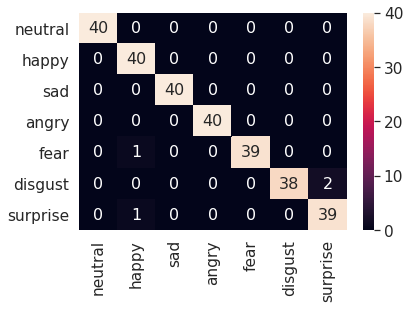

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

correlation between emotion intensity and corectness

In [ ]:
correct_strong = 0
correct_normal = 0
wrong_strong = 0
wrong_normal = 0
for i in range(len(X_test)):
    intensity = data.loc[test_ind[i],'Emotion intensity']
    if Y_test[i] == predictions[i]: # correct prediction
        if  intensity == 'normal':
            correct_normal += 1
        else:
            correct_strong += 1
    else: # wrong prediction
        if intensity == 'normal':
            wrong_normal += 1
        else:
            wrong_strong += 1
array = np.array([[wrong_normal,wrong_strong],[correct_normal,correct_strong]])
df = pd.DataFrame(array,['wrong','correct'],['normal','strong'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

correlation between gender and corectness

In [ ]:
correct_male = 0
correct_female = 0
wrong_male = 0
wrong_female = 0
for i in range(len(X_test)):
    gender = data.loc[test_ind[i],'Gender']
    if Y_test[i] == predictions[i]: # correct prediction
        if  gender == 'male':
            correct_male += 1
        else:
            correct_female += 1
    else: # wrong prediction
        if gender == 'male':
            wrong_male += 1
        else:
            wrong_female += 1
array = np.array([[wrong_male,wrong_female],[correct_male,correct_female]])
df = pd.DataFrame(array,['wrong','correct'],['male','female'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

# Plot loss

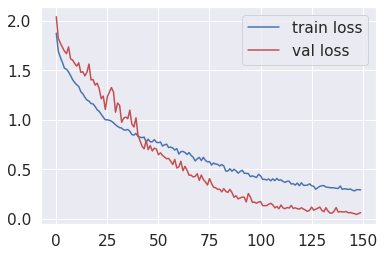

In [23]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])